# SMNLE

In [1]:
from experiments_utils.fetching import ResultsManager

In [2]:
r = ResultsManager("iclr_experiments_2")

In [3]:
def get_metadata(eres):
    num_unique_fields = eres.reset_index().apply(lambda x: len(x.unique()))
    nonunique_fields = list(num_unique_fields[num_unique_fields > 1].index.values)
    assert nonunique_fields == ['num_samples', 'num_observation', 'mmd', 'c2st'] , nonunique_fields
    
    return eres.reset_index()[nonunique_fields]

In [4]:
def format_unique_fielded_df(df, ebm_model_type, task):
    df = df.copy()
    
    if ebm_model_type == "likelihood":
        df['algorithm'] = "SUNLE"
    else:
        assert ebm_model_type == "joint_tilted"
        df['algorithm'] = "AUNLE"
        
    df['task'] = task
        
    num_simulations_str_map = {100000: "10⁵", 10000: "10⁴", 1000: "10³"}
    
    
    df['num_simulations'] = df.num_samples.apply(lambda x: num_simulations_str_map[sum(x)])
    df['num_rounds'] = df.num_samples.apply(len)
    
    df = df.drop("num_samples", axis=1)
    
    df = df.rename(columns={"c2st": "C2ST", "mmd": "MMD"})
    return df

In [5]:
r.results_df.shape

(228,)

In [10]:
configs = (
    dict(learning_rate=0.01, task="two_moons", ebm_model_type="joint_tilted", sampler="smc"),
    dict(learning_rate=0.01, task="two_moons", ebm_model_type="likelihood", sampler="mala", num_mala_steps=200, inference_num_warmup_steps=2000, max_iter=2000),
    dict(learning_rate=0.01, task="slcp", ebm_model_type="joint_tilted", sampler="smc"),
    dict(learning_rate=0.01, task="slcp", ebm_model_type="likelihood", sampler="mala", num_mala_steps=200, inference_num_warmup_steps=2000, max_iter=2000),
    dict(learning_rate=0.01, task="lotka_volterra", ebm_model_type="joint_tilted", sampler="smc"),
    dict(learning_rate=0.001, task="lotka_volterra", ebm_model_type="likelihood", sampler="mala", num_mala_steps=200, inference_num_warmup_steps=2000, max_iter=2000),
    dict(learning_rate=0.01, task="gaussian_linear_uniform", ebm_model_type="joint_tilted", sampler="smc"),
    dict(learning_rate=0.01, task="gaussian_linear_uniform", ebm_model_type="likelihood", sampler="mala", num_mala_steps=200, inference_num_warmup_steps=2000, max_iter=2000),
)

In [11]:
from sbibm import get_results
sbibm_results = get_results()
sbibm_results['num_rounds'] = [10 if m in ("SNRE", "SNPE", "SNLE") else 1 for m in sbibm_results.algorithm.values]

In [ ]:
sbibm_results_mini = sbibm_results[['task', 'num_simulations', "num_rounds", 'algorithm', 'num_observation', 'MMD', 'C2ST']]

In [ ]:
results = []
for i, c in enumerate(configs):
    eres = r.fetch_evaluation_results(**c)
    print(c, len(eres))
    df = get_metadata(eres)
    df = format_unique_fielded_df(df, c['ebm_model_type'], c["task"])
    results.append(df)

In [14]:
import pandas as pd
from sbibm.visualisation import fig_metric
all_unle_results = pd.concat(results, axis=0)
all_unle_results_f = all_unle_results.loc[(all_unle_results['algorithm'] == "AUNLE").values | (all_unle_results['num_rounds'] == 10).values]

In [15]:
all_results = pd.concat([sbibm_results_mini, all_unle_results_f], axis=0)

In [16]:
ar = all_results.set_index([c for c in all_results.columns if c not in ("MMD", "C2ST")])

In [17]:
num_simulations_str_map = {"10⁵": 100000, "10⁴": 10000, "10³": 1000}

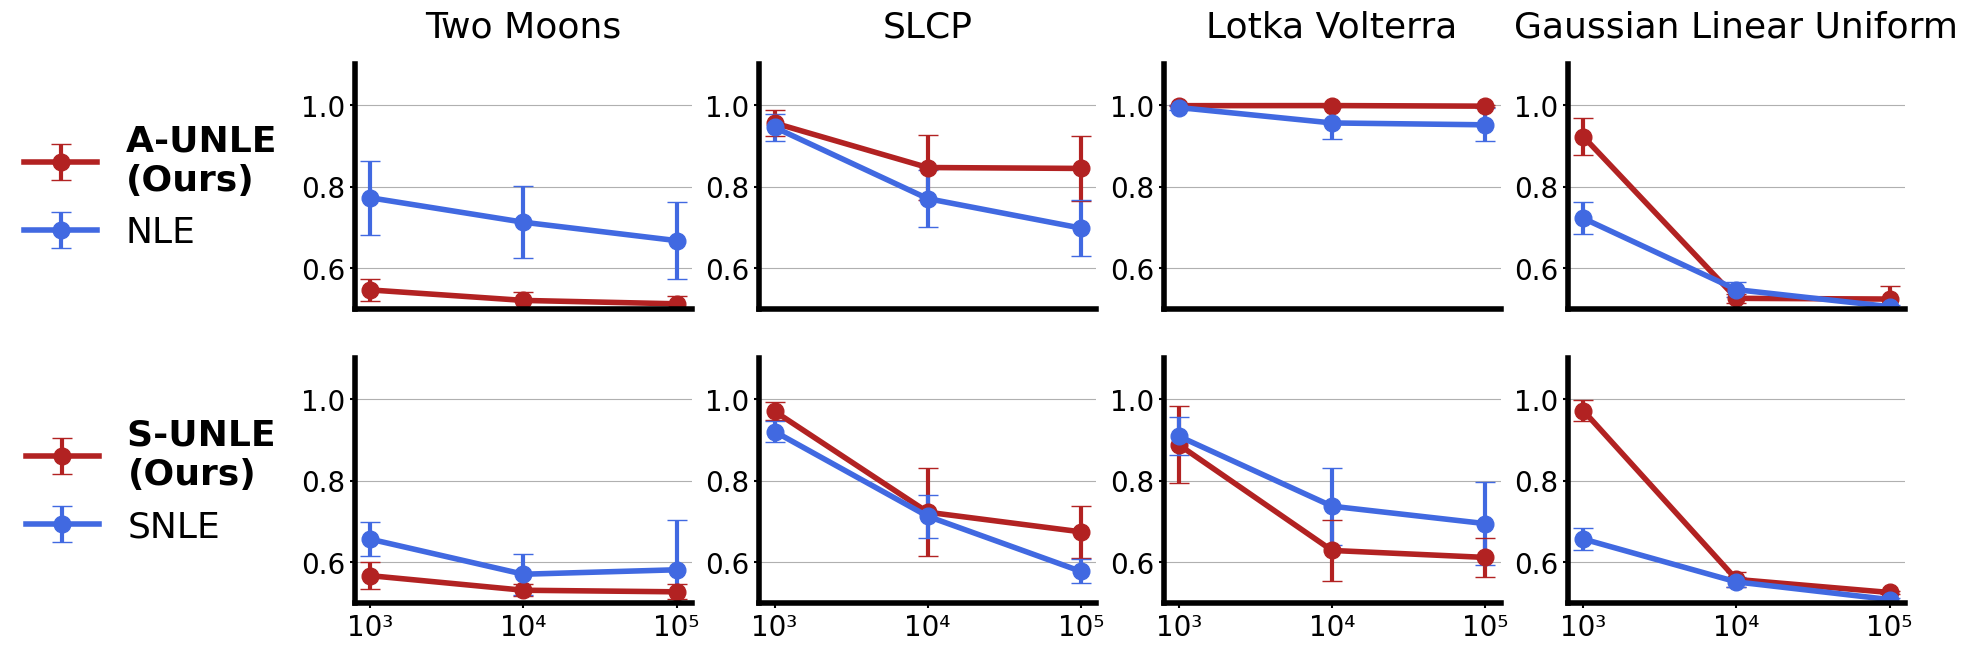

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt

pretty_names = {
    "two_moons": "Two Moons",
    "slcp": "SLCP",
    "gaussian_linear_uniform": "Gaussian Linear Uniform",
    "lotka_volterra": "Lotka Volterra"
}
metric = "C2ST"
limits_metric = {
    "MMD": (0, 1),
    "C2ST": (0.5, 1.1)
}

errorbar_kws = dict(
    linewidth=4,
    elinewidth=3,
    markersize=12,
    capsize=7, 
    marker="o"
)

fontsize=26
tk_fontsize=20

with mpl.rc_context(fname='.matplotlibrc'):
    mpl.rc('font',family='DejaVu Sans')
    mpl.rc("text", usetex=False)
    
    # ax.plot(
    #     "-+",
    # )
    tasks = ("two_moons", "slcp", "lotka_volterra", "gaussian_linear_uniform")
    f, axss = plt.subplots(ncols=len(tasks), nrows=2, figsize=(5 * len(tasks), 3.5 * 2))
    
    axs = axss[0]
    for t_no, task in enumerate(tasks):
        ax = axs[t_no]
        ax.grid(axis="y")
        for axis in ['bottom','left']:
            ax.spines[axis].set_linewidth(4)
            
        ax.errorbar(
            ar.xs(task, level="task").xs("AUNLE", level="algorithm").groupby("num_simulations")[metric].mean().index,
            ar.xs(task, level="task").xs("AUNLE", level="algorithm").groupby("num_simulations")[metric].mean(),
            ar.xs(task, level="task").xs("AUNLE", level="algorithm").groupby("num_simulations")[metric].std(),
            label="A-UNLE \n(Ours)",
            color="firebrick",
            **errorbar_kws
        )
        ax.set_ylim(*limits_metric[metric])

        ax.errorbar(
            ar.xs(task, level="task").xs("NLE", level="algorithm").groupby("num_simulations")[metric].mean().index,
            ar.xs(task, level="task").xs("NLE", level="algorithm").groupby("num_simulations")[metric].mean(),
            ar.xs(task, level="task").xs("NLE", level="algorithm").groupby("num_simulations")[metric].std(),
            label="NLE",
            color="royalblue",
            **errorbar_kws
        )

        ax.set_title(pretty_names[task], fontsize=fontsize, pad=20)
        ax.tick_params(axis='both', labelsize=tk_fontsize)
        ax.get_xaxis().set_ticks([])

        
    l = axs[0].legend(fontsize=fontsize, bbox_to_anchor=(-0.1, 0.5), bbox_transform=axs[0].transAxes, loc="center right")
    l.texts[0].set_weight("bold")
    
    axs = axss[1]
    for t_no, task in enumerate(tasks):
        ax = axs[t_no]
        ax.grid(axis="y")
        
        for axis in ['bottom','left']:
            ax.spines[axis].set_linewidth(4)
            
        ax.errorbar(
            ar.xs(task, level="task").xs("SUNLE", level="algorithm").groupby("num_simulations")[metric].mean().index,
            ar.xs(task, level="task").xs("SUNLE", level="algorithm").groupby("num_simulations")[metric].mean(),
            ar.xs(task, level="task").xs("SUNLE", level="algorithm").groupby("num_simulations")[metric].std(),
            label="S-UNLE \n(Ours)",
            # color="tomato",
            color="firebrick",
            **errorbar_kws
        )
        ax.set_ylim(*limits_metric[metric])

        ax.errorbar(
            ar.xs(task, level="task").xs("SNLE", level="algorithm").groupby("num_simulations")[metric].mean().index,
            ar.xs(task, level="task").xs("SNLE", level="algorithm").groupby("num_simulations")[metric].mean(),
            ar.xs(task, level="task").xs("SNLE", level="algorithm").groupby("num_simulations")[metric].std(),
            label="SNLE",
            # color="lightskyblue",
            color="royalblue",
            **errorbar_kws
        )

        # ax.set_title(pretty_names[task], fontsize=20)
        
        ax.tick_params(axis='both', labelsize=tk_fontsize)
        
    l = axs[0].legend(fontsize=fontsize, bbox_to_anchor=(-0.1, 0.5), bbox_transform=axs[0].transAxes, loc="center right")
    l.texts[0].set_weight("bold")
        
    # plt.errorbar(x, y + 3, yerr=yerr, label='both limits (default)')
    

    # ax.legend(fontsize=18)
    # 
    # ax.set_ylabel("Energy. Distance", fontsize=14)
    # ax.set_xlabel("Round No.", fontsize=14)
    
# f.savefig("figures/c2st_sbibm.pdf", dpi=300, bbox_inches='tight')